In [245]:
import io
import glob
from tqdm import tqdm 
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, \
                                    KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, \
                                  StandardScaler, OneHotEncoder, \
                                  LabelEncoder
from sklearn.metrics import f1_score, precision_score, \
                            recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, \
                             AdaBoostClassifier, \
                             GradientBoostingClassifier
from xgboost import XGBClassifier

import ast
pd.set_option('display.max_columns', 100)
import re
import requests
from bs4 import BeautifulSoup

## Load Dataset

We are using the latest data available (last month).

In [2]:
base_url = "https://webrobots.io"
data = requests.get(f"{base_url}/kickstarter-datasets/")
parsed = BeautifulSoup(data.text, "html.parser")
link = parsed.find("a", href=re.compile("Kickstarter_2023.*\.zip"))
zip_file_url = link["href"]
print(f"{zip_file_url}")

https://s3.amazonaws.com/weruns/forfun/Kickstarter/Kickstarter_2023-07-13T03_20_02_827Z.zip


In [3]:
r = requests.get(zip_file_url)
zf = zipfile.ZipFile(io.BytesIO(r.content))
dfs = [pd.read_csv(zf.open(f)) for f in zf.namelist()]
df = pd.concat(dfs,ignore_index=True)

In [4]:
#df.to_parquet('july2023.parquet')

In [5]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type
0,31,"Learn how we farm meat, eggs, & produce with r...","{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",1413.0,US,the United States,1683033932,"{""id"":938227938,""name"":""Nick & Ashley Riggin"",...",USD,$,True,USD,1690768800,False,NaN,1.00000,2500.0,1625948005,NaN,True,NaN,1688203166,"{""id"":2503690,""name"":""Talking Rock"",""slug"":""ta...",Foodie Farmers: A Culinary Journey From Farm T...,NaN,"{""key"":""assets/041/346/542/c9cdd498a76a65def92...",1413.0,"{""id"":4610356,""project_id"":4610356,""state"":""in...",foodie-farmers-a-culinary-journey-from-farm-to...,https://www.kickstarter.com/discover/categorie...,False,True,live,1688203169,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.00000,1413.000000,international
1,25,A mystical family cookbook of every day comfor...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",1121.0,US,the United States,1686078022,"{""id"":1474311749,""name"":""Mia Jauch"",""slug"":""ho...",USD,$,True,USD,1692692567,False,NaN,1.00000,3000.0,1286583750,NaN,True,NaN,1687508567,"{""id"":2436704,""name"":""Las Vegas"",""slug"":""las-v...",The Hovel Hungries: A Mystical Family Cookbook,NaN,"{""key"":""assets/041/296/498/c65cfd2fded76fb28fb...",1121.0,"{""id"":4632365,""project_id"":4632365,""state"":""in...",the-hovel-hungries-a-mystical-family-cookbook,https://www.kickstarter.com/discover/categorie...,False,True,live,1687508569,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.00000,1121.000000,international
2,6,Help launch a book of balanced nutrition in th...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",46.0,AT,Austria,1686754127,"{""id"":878754527,""name"":""Tetiana Litvinova and ...",EUR,€,False,USD,1692463921,False,NaN,1.10297,3500.0,921287736,NaN,True,NaN,1687279921,"{""id"":550763,""name"":""Innsbruck"",""slug"":""innsbr...",The Cookbook by Nutritionist and Culinary Expert,NaN,"{""key"":""assets/041/294/025/7cc64e0e056b899bf79...",42.0,"{""id"":4637258,""project_id"":4637258,""state"":""in...",the-cookbook-by-nutritionist-and-culinary-expert,https://www.kickstarter.com/discover/categorie...,False,False,live,1687279923,1.093759,"{""web"":{""project"":""https://www.kickstarter.com...",1.10297,45.937888,international
3,62,Fudge recipes from Portland's favorite artisan...,"{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",3122.0,US,the United States,1680037495,"{""id"":1660854404,""name"":""Samantha Kirsch"",""is_...",USD,$,True,USD,1689577140,False,NaN,1.00000,3000.0,1205777113,NaN,True,NaN,1686927260,"{""id"":2475687,""name"":""Portland"",""slug"":""portla...",The Official Mudge Fudge Cookbook,NaN,"{""key"":""assets/041/274/922/16ca110ff301757d061...",3122.0,"{""id"":4588002,""project_id"":4588002,""state"":""in...",the-official-mudge-fudge-cookbook,https://www.kickstarter.com/discover/categorie...,False,False,live,1686927263,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.00000,3122.000000,international
4,0,"A Collection of Cherished Southern Recipes, Re...","{""id"":306,""name"":""Cookbooks"",""analytics_name"":...",NaN,US,the United States,1637256549,"{""id"":858930763,""name"":""Rebecca Wood"",""slug"":""...",USD,$,True,USD,0,False,NaN,1.00000,0.0,641679471,NaN,True,NaN,0,"{""id"":2457170,""name"":""Nashville"",""slug"":""nashv...",The Studio Mama Cookbook,NaN,"{""key"":""assets/035/626/294/57704752dd42c42a509...",0.0,"{""id"":4311553,""project_id"":4311553,""state"":""in...",the-studio-mama-cookbook,https://www.kickstarter.com/discover/categorie...,False

In [6]:
print ("Number of projects: ", df.shape[0], "\nNumber of columns (features): ", df.shape[1])

Number of projects:  24723 
Number of columns (features):  39


## Split into train/validation/test set

The general rule is to split the data first, then apply any preprocessing steps (feature scaling, feature selection, feature engineering) on the training data, and propagate the same transformations to the validation and test data. This ensures that your model is evaluated fairly and prevents any data leakage from influencing your results.

The *state* column shows the outcome of the project. We are focused on predicting whether projects succeed or fail. Therefore, we remove the canceled, live, submitted, started, and suspended states:

In [7]:
df = df[df["state"].isin(["failed", "successful"])]

In [8]:
SEED = 1234

# X = df.drop('state', axis=1)
# y = df['state']

# Stratify based on the 'state' column (target variable)

X_train, X_test = train_test_split(df, 
                                   test_size=.15, 
                                   stratify=df['state'],
                                   random_state=SEED)
 
X_train, X_val = train_test_split(X_train,
                                  test_size=.18, 
                                  stratify=X_train['state'],
                                  random_state=SEED)

In [9]:
print(f'Shape train: X: {X_train.shape}')
print(f'Shape valid: X: {X_val.shape}')
print(f'Shape test: X: {X_test.shape}')

Shape train: X: (15634, 39)
Shape valid: X: (3433, 39)
Shape test: X: (3365, 39)


Verify the split retains a balanced target feature (*state*):

In [10]:
print(f'Train: {X_train["state"].value_counts()}\n')
print(f'Valid: {X_val["state"].value_counts()}\n')
print(f'Test: {X_test["state"].value_counts()}')

Train: state
successful    10596
failed         5038
Name: count, dtype: int64

Valid: state
successful    2327
failed        1106
Name: count, dtype: int64

Test: state
successful    2281
failed        1084
Name: count, dtype: int64


## Dataset Preprocessing to EDA

### Remove columns with missing values

Column names and number of missing values:

In [11]:
X_train.isna().sum()

backers_count                   0
blurb                           0
category                        0
converted_pledged_amount        0
country                         0
country_displayable_name        0
created_at                      0
creator                         0
currency                        0
currency_symbol                 0
currency_trailing_code          0
current_currency                0
deadline                        0
disable_communication           0
friends                     15630
fx_rate                         0
goal                            0
id                              0
is_backing                  15630
is_starrable                    0
is_starred                  15630
launched_at                     0
location                       28
name                            0
permissions                 15630
photo                           0
pledged                         0
profile                         0
slug                            0
source_url    

Description of each column:
   - *backers_count* (int) : number of individuals who contributed funds to support the project
   - *blurb* (str) : a concise and short description of the project.
   - *category* (dict as str) : contains information about the project's category and sub-category
   - *converted_pledged_amount* (float) : amount of money pledged, converted to the currency indicated in the *current_currency* column
   - *country* (str) : Acronym of country from which the project creator originates
   - *country_displayable_name* (str) : full name of the country
   - *created_at* (int) : the date and time when the project was initially created on Kickstarter
   - *creator* (dict as str) : information about the project creator, including their name and Kickstarter ID number
   - *currency* (str) : original currency in which the project's funding goal was denominated
   - *currency_symbol* (str) :  symbol representing the original currency in which the project's funding goal was denominated
   - *currency_trailing_code* (bool) : code of the original currency in which the project's funding goal was denominated
   - *current_currency* (str) : the currency to which the project's funding goal was converted
   - *deadline* (int) - The date and time when the project will close for receiving donations
   - *disable_communication* (bool) : whether the project owner has disabled communication with their backers
   - *friends* : unclear information (could be null or false)
   - *fx_rate* (float) : The foreign exchange rate between the original currency and the current_currency
   - *goal* (float) : funding goal in original currency
   - *id* (int) : id number of the project
   - *is_backing* : unclear information (could be null or false)
   - *is_starrable* (bool) : indicates whether users can star (like and save) the project
   - *is_starred* (bool) : whether the project has been starred (liked and saved) by users
   - *launched_at* (int) : The date and time when the project was launched for funding
   - *location* (dict as str) : contains information about the town or city of the project creator
   - *name* (str) : name of the project
   - *permissions* : unclear information (could be null or false)
   - *photo* (dict as str) : contains a link and information related to the project's photo(s)
   - *pledged* (float) : the amount pledged in the original currency
   - *profile* (dict as str) : Details about the project's profile, including ID number and various visual settings
   - *slug* (str) : name of the project with hyphens instead of spaces
   - *source_url* (str) : url for the project's category
   - *spotlight* (bool) : whether a project has been successful and is spotlighted on the Kickstarter website
   - *staff_pick* (bool) : indicates whether a project was highlighted as a staff pick when it was launched/live
   - *state* (bool) : the current state of the project, whether it is successful, failed, canceled, suspending, or still live
   - *state_changed_at* (int) : The date and time when a project's status was changed (same as the deadline for successful and failed projects)
   - *static_usd_rate* (float) : The conversion rate between the original currency and USD
   - *urls* (dict as str) : urls to the project's page
   - *usd_exchange_rate* (float) : similar to *static_usd_rate*
   - *usd_pledged* (float) - The amount pledged in USD
   - *usd_type* (str) - indicates whether the project's funding is domestic or international

Remove columns with high proportion of missing values using a pipeline (so that it can be applied to validation and test sets as well)

In [12]:
# Custom transformer to drop columns with missing values
class ColumnDropperTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [13]:
# Define function to create a pipeline with  
# ColumnTransformer to handle missing 
# values and drop columns
def create_drop_cols_pipeline(columns_to_drop):
    pipeline = Pipeline([
        ("columnDropper", ColumnDropperTransformer(columns_to_drop))
    ])
    return pipeline

In [14]:
cols_to_drop = ['converted_pledged_amount', 'friends', 'is_backing', 
                'is_starred', 'location', 'permissions', 
                'usd_exchange_rate', 'usd_pledged', 'usd_type']

pipeline = create_drop_cols_pipeline(cols_to_drop)

In [15]:
# apply the pipeline to training data
X_train_clean = pipeline.fit_transform(X_train)
X_train_clean.isna().sum()

backers_count               0
blurb                       0
category                    0
country                     0
country_displayable_name    0
created_at                  0
creator                     0
currency                    0
currency_symbol             0
currency_trailing_code      0
current_currency            0
deadline                    0
disable_communication       0
fx_rate                     0
goal                        0
id                          0
is_starrable                0
launched_at                 0
name                        0
photo                       0
pledged                     0
profile                     0
slug                        0
source_url                  0
spotlight                   0
staff_pick                  0
state                       0
state_changed_at            0
static_usd_rate             0
urls                        0
dtype: int64

In [16]:
# apply the pipeline to validation and test set
X_val_clean = pipeline.transform(X_val)
X_test_clean = pipeline.transform(X_test)

In [17]:
# df.drop(['converted_pledged_amount', 'friends', 'is_backing', 'is_starred',
#          'location','permissions', 'usd_exchange_rate', 'usd_pledged', 'usd_type'],
#           axis=1, inplace=True)

### Remove irrelevant columns 


We further remove:

- *country_displayable_name* : redundant to *country*
- *creator* : the majority of projects have different creators  
- *currency* : All currency values will be unified and converted to dollars, enabling them to be assessed collectively
- *currency_symbol* : likewise
- *currency_trailing_code* : likewise
- *current_currency* : likewise
- *fx_rate* : dropped in favor of 'static_usd_rate'
- *is_starrable* : not relevant when *is_starred* is not given
- *photo* : we are not analyzing images
- *profile* : irrelevant information
- *slug* : repetition of *name* column
- *source_url* : irrelevant information
- *spotlight* : proxy for *state*
- *state_changed_at* : similar to *deadline* for most projects
- *urls* : bound to *source_url*

In [18]:
cols_to_drop = ['country_displayable_name', 'creator', 'currency', 'currency_symbol',
                'currency_trailing_code', 'current_currency', 'fx_rate', 'is_starrable',
                'photo', 'profile', 'slug', 'source_url', 'spotlight',
                'state_changed_at', 'urls']

In [19]:
# df.drop(['country_displayable_name', 'creator', 'currency', 'currency_symbol',
#          'currency_trailing_code', 'current_currency', 'fx_rate', 'is_starrable',
#          'location', 'photo', 'profile', 'slug', 'source_url', 'spotlight',
#          'state_changed_at', 'urls'],
#           axis=1, inplace=True)

Finally, knowing that mostly all values of *disable_communication* are ```False```, we can drop it too.

In [20]:
X_train_clean['disable_communication'].value_counts()

disable_communication
False    15634
Name: count, dtype: int64

In [21]:
cols_to_drop.append('disable_communication')

In [22]:
pipeline = create_drop_cols_pipeline(cols_to_drop)

X_train_clean = pipeline.fit_transform(X_train_clean)
X_val_clean = pipeline.transform(X_val_clean)
X_test_clean = pipeline.transform(X_test_clean)

In [23]:
# df.drop(['disable_communication'], axis=1, inplace=True)

Finally, we have these remaining columns:

In [24]:
X_train_clean.isna().sum()

backers_count      0
blurb              0
category           0
country            0
created_at         0
deadline           0
goal               0
id                 0
launched_at        0
name               0
pledged            0
staff_pick         0
state              0
static_usd_rate    0
dtype: int64

### Remove duplicate projects

We can now check if there are duplicate projects in the dataset (same ID):

In [25]:
print(f'We have {len(X_train_clean[X_train_clean.duplicated(subset="id")])}',
      f'duplicate projects out of {len(X_train_clean)}')

We have 259 duplicate projects out of 15634


Duplicates (rows) can be removed by using a pipeline:

In [26]:
# df.drop_duplicates(inplace=True)

In [27]:
# Custom transformer to remove rows with the same ID
class DropRowsWithSameIDTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, id_column):
        self.id_column = id_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Get the index of unique rows based on the ID column in X
        unique_indices = X[self.id_column].drop_duplicates().index

        # Filter X and y based on the unique indices
        X_cleaned = X.loc[unique_indices]

        return X_cleaned

In [28]:
# Create a pipeline using FeatureUnion to handle X and y separately
pipeline = Pipeline([
    ('drop_rows', DropRowsWithSameIDTransformer(id_column='id'))  
])

In [29]:
X_train_clean = pipeline.fit_transform(X_train_clean)

In [30]:
X_val_clean = pipeline.transform(X_val_clean)
X_test_clean = pipeline.transform(X_test_clean)

In [31]:
print(f'Duplicates remaining: {len(X_test_clean[X_test_clean.duplicated(subset="id")])}')

Duplicates remaining: 0


### Convert to datetime

The columns that hold dates are stored in Unix time and require conversion to datetime format. Since they were initially converted from Unix, all times are in UTC/GMT.

In [32]:
X_train_clean.iloc[0,:][['created_at', 'deadline', 'launched_at']]

created_at     1597156625
deadline       1601384400
launched_at    1599289963
Name: 14733, dtype: object

In [33]:
# date_unix = ['created_at', 'deadline', 'launched_at']
# # Convert each column to datetime format
# df[date_unix] = df[date_unix].apply(pd.to_datetime, 
#                                     origin='unix', unit='s')

In [34]:
# Define the transformer function to convert columns to datetime format
def to_datetime_transformer(data, columns):
    data[columns] = data[columns].apply(pd.to_datetime, 
                                        origin='unix', unit='s')
    return data

In [35]:
# Create the pipeline
date_unix = ['created_at', 'deadline', 'launched_at']
date_transformer = FunctionTransformer(to_datetime_transformer, kw_args={'columns': date_unix})

pipeline = Pipeline([
    ('date_transformer', date_transformer)
])

In [36]:
X_train_clean = pipeline.fit_transform(X_train_clean)
X_val_clean = pipeline.transform(X_val_clean)
X_test_clean = pipeline.transform(X_test_clean)

In [37]:
X_train_clean.iloc[0,:][['created_at', 'deadline', 'launched_at']]

created_at     2020-08-11 14:37:05
deadline       2020-09-29 13:00:00
launched_at    2020-09-05 07:12:43
Name: 14733, dtype: object

We can observe the earliest and latest project in the training dataset:

In [38]:
print(f'Dataset of Kickstarter projects from {min(X_train_clean.created_at).strftime("%d %B %Y")}',
      f'to {max(X_train_clean.created_at).strftime("%d %B %Y")}')

Dataset of Kickstarter projects from 25 April 2009 to 03 July 2023


### Categories and sub-categories

The category column is stored as a JSON string. We can extract the main and sub-categories as separate columns:

In [39]:
X_train_clean.iloc[0,:]['category']

'{"id":313,"name":"Small Batch","analytics_name":"Small Batch","slug":"food/small batch","position":10,"parent_id":10,"parent_name":"Food","color":16725570,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/food/small%20batch"}}}'

In [40]:
# # Function to extract "parent_name" and "name" from the "category" column
# def extract_category_info(category_str):
#     # Convert the JSON-like string to a dictionary
#     category_dict = ast.literal_eval(category_str)  
#     words = category_dict['slug'].split('/')
#     # In case there is no subcategory
#     if len(words) < 2:
#         words.append('no subcategory')
#     return words

In [41]:
# # Apply the function to create new columns "category" and "sub_category"
# df[['main_category', 'sub_category']] =  df['category'].apply(lambda x: pd.Series(extract_category_info(x)))

# # Drop the original "category" column
# df.drop(columns=['category'], inplace=True)

In [42]:
# Function to extract "parent_name" and "name" from the "category" column
def extract_category_info(category_str):
    # Convert the JSON-like string to a dictionary
    category_dict = ast.literal_eval(category_str)  
    words = category_dict['slug'].split('/')
    # In case there is no subcategory
    if len(words) < 2:
        words.append('no subcategory')
    return words

# Define a separate function for the "category" column transformation
def category_transformation(data):
    return data['category'].apply(lambda y: pd.Series(extract_category_info(y),
                                                     index=['main_category', 'sub_category']))

In [43]:
# 1. Extract "main_category" and "sub_category"
# 2. Drop the original "category" column
column_transformer = ColumnTransformer(
    transformers=[
        ('category_info', FunctionTransformer(category_transformation, 
                                              validate=False), ['category']),
        ('drop_category', 'drop', ['category'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
# Set the output as DataFrame
column_transformer.set_output(transform="pandas")

/home/javi/miniconda3/envs/mlops-zoomcamp/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('category_info',
                                 FunctionTransformer(func=<function category_transformation at 0x7f6c87bb9cf0>),
                                 ['category']),
                                ('drop_category', 'drop', ['category'])],
                  verbose_feature_names_out=False)

In [44]:
pipeline = Pipeline([
    ('column_transformer', column_transformer)
])

In [45]:
X_train_clean = pipeline.fit_transform(X_train_clean)

In [46]:
X_val_clean = pipeline.transform(X_val_clean)
X_test_clean = pipeline.transform(X_test_clean)

In [47]:
X_train_clean.iloc[0,:]

main_category                                                   food
sub_category                                             small batch
backers_count                                                    403
blurb              Why are we still eating long-life chocolate - ...
country                                                           GB
created_at                                       2020-08-11 14:37:05
deadline                                         2020-09-29 13:00:00
goal                                                          7700.0
id                                                        1650127817
launched_at                                      2020-09-05 07:12:43
name                     Russell and Atwell - the fresh chocolatiers
pledged                                                      14278.0
staff_pick                                                      True
state                                                     successful
static_usd_rate                   

In [48]:
# Number of unique main categories and sub-categories for training set
print(f"{X_train_clean['main_category'].nunique()} unique main categories.\n")
print(X_train_clean['main_category'].value_counts(), '\n')

print(f"{X_train_clean['sub_category'].nunique()} unique sub-categories.\n")
print(X_train_clean['sub_category'].value_counts())

9 unique main categories.

main_category
food            2269
music           2230
technology      2152
publishing      1892
journalism      1788
film & video    1556
theater         1475
design          1062
comics           951
Name: count, dtype: int64 

37 unique sub-categories.

sub_category
comedy                1556
pop                   1468
software              1430
fiction               1362
plays                 1290
webcomics              951
product design         874
no subcategory         726
sound                  722
cookbooks              568
audio                  462
r&b                    460
web                    351
literary journals      305
punk                   302
print                  294
drinks                 281
community gardens      249
spaces                 243
small batch            220
restaurants            203
literary spaces        151
photo                  144
bacon                  133
vegan                  113
toys                   105


### Convert Goal and pledge to USD 

The funding goals and pledges for each project are currently registered in their respective native currencies. To ensure equitable comparisons between projects, these columns will be converted into dollars

In [49]:
# df['usd_goal']   = round(df['goal'] * df['static_usd_rate'],2)
# df['usd_pledged'] = round(df['pledged'] * df['static_usd_rate'],2)

In [50]:
# # Dropping 'goal' and 'static_usd_rate'
# df.drop(['goal', 'pledged', 'static_usd_rate'], axis=1, inplace=True)

In [51]:
def calculate_usd_goal(data):
    usd_goal = data['goal'] * data['static_usd_rate']
    return pd.DataFrame(usd_goal, columns=['usd_goal'])

def calculate_usd_pledged(data):
    usd_pledged = data['pledged'] * data['static_usd_rate']
    return pd.DataFrame(usd_pledged, columns=['usd_pledged'])

column_transformer = ColumnTransformer(
    transformers=[
        ('usd_goal', FunctionTransformer(calculate_usd_goal, validate=False), 
                                         ['goal', 'static_usd_rate']),
        ('usd_pledged', FunctionTransformer(calculate_usd_pledged, validate=False), 
                                         ['pledged', 'static_usd_rate']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer.set_output(transform="pandas")

pipeline = Pipeline([
    ('column_transformer', column_transformer)
])

/home/javi/miniconda3/envs/mlops-zoomcamp/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [52]:
X_train_clean = pipeline.fit_transform(X_train_clean)
X_val_clean = pipeline.transform(X_val_clean)
X_test_clean = pipeline.transform(X_test_clean)

In [53]:
X_train_clean.iloc[0,:]

usd_goal                                              10225.763625
usd_pledged                                           18961.487408
main_category                                                 food
sub_category                                           small batch
backers_count                                                  403
blurb            Why are we still eating long-life chocolate - ...
country                                                         GB
created_at                                     2020-08-11 14:37:05
deadline                                       2020-09-29 13:00:00
id                                                      1650127817
launched_at                                    2020-09-05 07:12:43
name                   Russell and Atwell - the fresh chocolatiers
staff_pick                                                    True
state                                                   successful
Name: 14733, dtype: object

### Feature Engineering

1. **Name and description** How the project name or description is written may affect the success of the project. So we create some features related to the number of words used in project name and description. The original name variable will then be dropped.

In [54]:
# # name length
# df['name_length'] = df['name'].str.split().str.len()
# # remove 'name' column
# df.drop('name', axis=1, inplace=True)

In [55]:
# # description length
# df['description_length'] = df['blurb'].str.split().str.len()
# # remove 'blurb' column
# df.drop('blurb', axis=1, inplace=True)

In [56]:
# # Check for missing lengths 
# df.isna().sum()

In [57]:
# # Replacing null values for length 0
# df['description_length'].fillna(0, inplace=True)

In [58]:
def calculate_name_length(data):
    return data['name'].str.split().str.len().to_frame('name_length')

def calculate_description_length(data):
    description_length = data['blurb'].str.split().str.len()
    # Make sure to replace null values for length 0
    return description_length.fillna(0).to_frame('description_length')

column_transformer = ColumnTransformer(
    transformers=[
        ('name_length', FunctionTransformer(calculate_name_length, validate=False), ['name']),
        ('description_length', FunctionTransformer(calculate_description_length, validate=False), ['blurb']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer.set_output(transform="pandas")

pipeline = Pipeline([
    ('column_transformer', column_transformer)
])

/home/javi/miniconda3/envs/mlops-zoomcamp/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [59]:
X_train_clean = pipeline.fit_transform(X_train_clean)
X_val_clean   = pipeline.transform(X_val_clean)
X_test_clean  = pipeline.transform(X_test_clean)

In [60]:
X_train_clean.iloc[0,:]

name_length                             7
description_length                     20
usd_goal                     10225.763625
usd_pledged                  18961.487408
main_category                        food
sub_category                  small batch
backers_count                         403
country                                GB
created_at            2020-08-11 14:37:05
deadline              2020-09-29 13:00:00
id                             1650127817
launched_at           2020-09-05 07:12:43
staff_pick                           True
state                          successful
Name: 14733, dtype: object

2. **Time related features** We calculate time from creation to launch and campaign length 

In [61]:
# # Time between creating and launching a project (hours)
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h')

# # Campaign duration (hours)
# df['campaign_hours'] = df['deadline'] - df['launched_at']
# df['campaign_hours'] = df['campaign_hours'].dt.round('d').dt.round('h') / np.timedelta64(1, 'h')

In [62]:
# Time between creating and launching a project (hours)
def calculate_creation_to_launch_hours(data):
    creation_to_launch_hours = (data['launched_at'] - data['created_at']).dt.round('h') / np.timedelta64(1, 'h')
    return pd.DataFrame(creation_to_launch_hours, columns=['creation_to_launch_hours'])

# Campaign duration (hours)
def calculate_campaign_hours(data):
    campaign_hours = (data['deadline'] - data['launched_at']).dt.round('d').dt.round('h') / np.timedelta64(1, 'h')
    return pd.DataFrame(campaign_hours, columns=['campaign_hours'])

column_transformer = ColumnTransformer(
    transformers=[
        ('creation_to_launch_hours', FunctionTransformer(calculate_creation_to_launch_hours, validate=False), ['created_at', 'launched_at']),
        ('campaign_hours', FunctionTransformer(calculate_campaign_hours, validate=False), ['launched_at', 'deadline']),
        ('passthrough', 'passthrough', ['created_at', 'launched_at', 'deadline'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer.set_output(transform="pandas")

pipeline = Pipeline([
    ('column_transformer', column_transformer)
])

/home/javi/miniconda3/envs/mlops-zoomcamp/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [63]:
X_train_clean = pipeline.fit_transform(X_train_clean)
X_val_clean   = pipeline.transform(X_val_clean)
X_test_clean  = pipeline.transform(X_test_clean)

In [64]:
X_train_clean.iloc[0,:]

creation_to_launch_hours                  593.0
campaign_hours                            576.0
created_at                  2020-08-11 14:37:05
launched_at                 2020-09-05 07:12:43
deadline                    2020-09-29 13:00:00
name_length                                   7
description_length                           20
usd_goal                           10225.763625
usd_pledged                        18961.487408
main_category                              food
sub_category                        small batch
backers_count                               403
country                                      GB
id                                   1650127817
staff_pick                                 True
state                                successful
Name: 14733, dtype: object

3. **Project Category Features** We calculate which is the median goal in those main/sub categories. Then we compute a new column with the difference between the median and the current category's goal. This gives an idea if the project's goal is much higher or much lower than the median goal of the main/sub category it belongs to.

In [65]:
# Median for main categories
X_train_clean.groupby("main_category")['usd_goal'].agg('median')

main_category
comics           3122.000000
design           4000.000000
film & video     5000.000000
food             7969.651500
journalism       3777.830475
music            3500.000000
publishing       1825.571350
technology      14589.498000
theater          3260.825625
Name: usd_goal, dtype: float64

In [66]:
# Median for sub categories
X_train_clean.groupby("sub_category")['usd_goal'].agg('median')

sub_category
architecture           5918.679700
audio                  2500.000000
bacon                  5000.000000
civic design           3000.000000
comedy                 5000.000000
community gardens      5800.000000
cookbooks              6000.000000
drinks                 9685.874960
events                 6000.000000
farmer's markets       3000.000000
farms                  5000.000000
fiction                1196.192475
food trucks            9450.000000
graphic design          500.000000
interactive design     1065.770008
letterpress            3896.402253
literary journals      3000.000000
literary spaces        8933.474175
no subcategory         5000.000000
photo                  4000.000000
plays                  3000.000000
pop                    3904.837275
print                  3500.000000
product design         4946.584474
punk                   1893.442960
r&b                    5000.000000
restaurants           20000.000000
small batch            5491.474525
softwar

In [67]:
# median_main = df.groupby("main_category")['usd_goal'].transform('median')
# df['diff_main_category_goal'] = abs(median_main - df['usd_goal'])

In [68]:
# median_sub = df.groupby("sub_category")['usd_goal'].transform('median')
# df['diff_sub_category_goal'] = abs(median_sub - df['usd_goal'])

In [69]:
# To ensure consistency and prevent data leakage, we should calculate
# the medians on the training set and use the same median values for
# transforming the validation and test sets 

def calculate_diff_main_category_goal(data, medians):
    main_categories = data['main_category'].values
    median_main = medians['main_category'][main_categories].values
    return abs(data['usd_goal'] - median_main).to_frame('diff_main_category_goal')

def calculate_diff_sub_category_goal(data, medians):
    sub_categories = data['sub_category'].values
    median_sub = medians['sub_category'][sub_categories].values
    return abs(data['usd_goal'] - median_sub).to_frame('diff_sub_category_goal')

In [70]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.medians = None

    def fit(self, X, y=None):
        self.medians = {
            'main_category': X.groupby("main_category")['usd_goal'].median(),
            'sub_category': X.groupby("sub_category")['usd_goal'].median()
        }
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed['diff_main_category_goal'] = calculate_diff_main_category_goal(X_transformed, self.medians)
        X_transformed['diff_sub_category_goal'] = calculate_diff_sub_category_goal(X_transformed, self.medians)
        return X_transformed

pipeline = Pipeline([
    ('transformer', CustomTransformer()),
    ('passthrough', 'passthrough')
])

In [71]:
X_train_clean = pipeline.fit_transform(X_train_clean)
X_val_clean   = pipeline.transform(X_val_clean)
X_test_clean  = pipeline.transform(X_test_clean)

In [72]:
X_train_clean.iloc[0,:]

creation_to_launch_hours                  593.0
campaign_hours                            576.0
created_at                  2020-08-11 14:37:05
launched_at                 2020-09-05 07:12:43
deadline                    2020-09-29 13:00:00
name_length                                   7
description_length                           20
usd_goal                           10225.763625
usd_pledged                        18961.487408
main_category                              food
sub_category                        small batch
backers_count                               403
country                                      GB
id                                   1650127817
staff_pick                                 True
state                                successful
diff_main_category_goal             2256.112125
diff_sub_category_goal                4734.2891
Name: 14733, dtype: object

### EDA : How has fundraising changed over time? 


We perform a brief exploratory data analysis of the training set

In [73]:
# Separate successful and failed projects
successful_projects = X_train_clean[X_train_clean['state'] == 'successful']
failed_projects = X_train_clean[X_train_clean['state'] == 'failed']

#### Plotting the number of projects launched each month

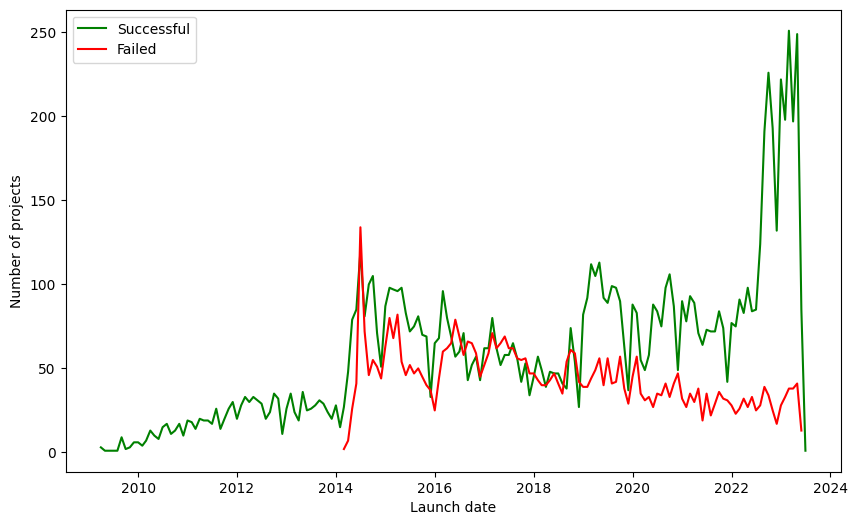

In [74]:
# Group by month and count the number of projects for each group
# dates are resampled to the first of the month

successful_counts = successful_projects \
                         .set_index('launched_at') \
                         .resample('MS').size()
failed_counts = failed_projects  \
                         .set_index('launched_at') \
                         .resample('MS').size()

plt.figure(figsize=(10, 6))
plt.plot(successful_counts, label='Successful', color='g')
plt.plot(failed_counts, label='Failed', color='r')
plt.xlabel('Launch date')
plt.ylabel('Number of projects')
plt.legend()
plt.show()

#### Plotting the cumulative number of backers on Kickstarter

In [75]:
# Calculate the cumulative sum of backers 
cumulative_backers = X_train_clean.set_index('launched_at') \
                       .sort_index()['backers_count'] \
                       .cumsum()

# Group by year and calculate the number of backers for successful and failed projects
backers_per_year = X_train_clean.groupby([X_train_clean['launched_at'].dt.year, 'state'])['backers_count'] \
                  .sum() \
                  .to_frame(name = 'sum_backers').reset_index()

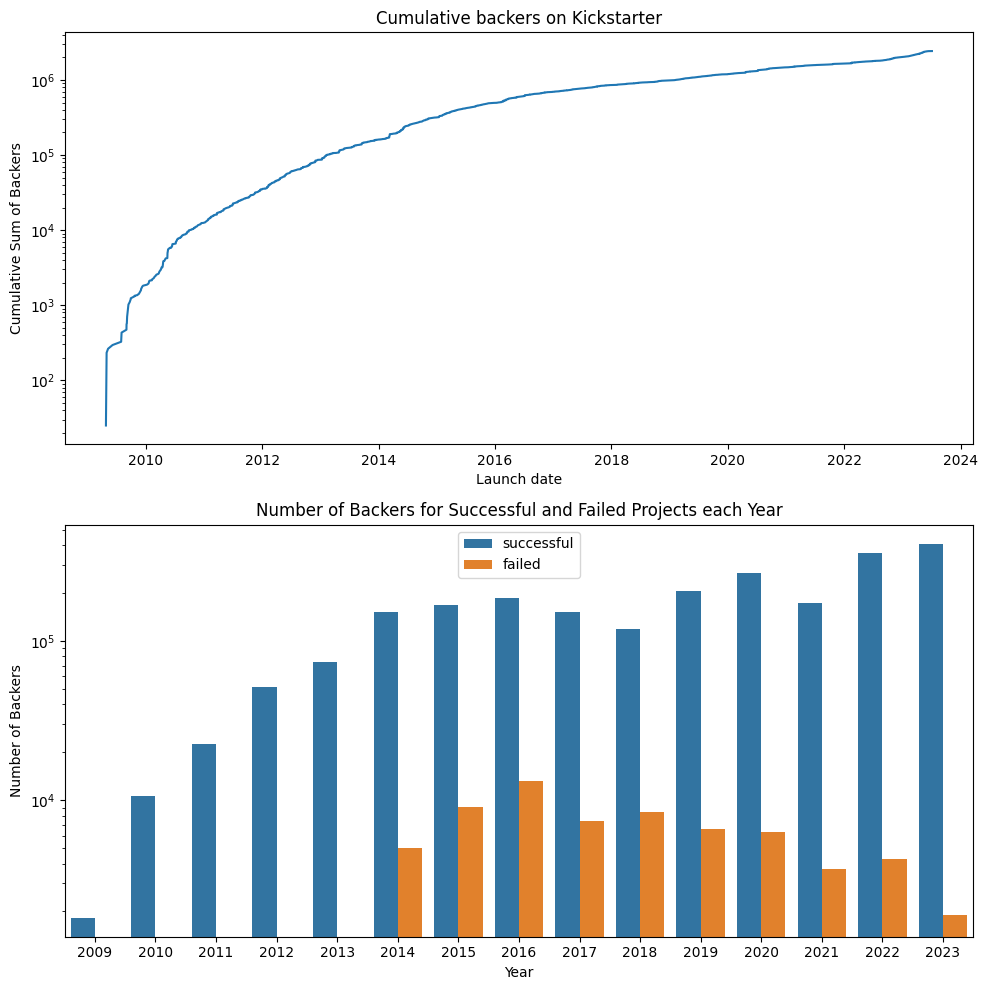

In [76]:
plt.figure(figsize=(10, 10))

# Plotting the cumulative sum of backers per month (line plot)
plt.subplot(2, 1, 1)
plt.plot(cumulative_backers)
plt.xlabel('Launch date')
plt.ylabel('Cumulative Sum of Backers')
plt.yscale('log')
plt.title('Cumulative backers on Kickstarter')

# Plotting the number of backers for successful and failed projects each year (bar plot)
plt.subplot(2, 1, 2)
sns.barplot(data=backers_per_year,
            x='launched_at',
            y='sum_backers',
            hue='state')
plt.xlabel('Year')
plt.ylabel('Number of Backers')
plt.yscale('log')
plt.title('Number of Backers for Successful and Failed Projects each Year')
plt.legend()

plt.tight_layout()
plt.show()

#### Plotting the cumulative USD pledges on Kickstarter

In [77]:
cumulative_pledges = X_train_clean.set_index('launched_at') \
                       .sort_index()['usd_pledged'] \
                       .cumsum()

# Group by year and calculate the number of backers for successful and failed projects
pledges_per_year = X_train_clean.groupby([X_train_clean['launched_at'].dt.year, 'state'])['usd_pledged'] \
                  .sum() \
                  .to_frame(name = 'sum_usd_pledged').reset_index()

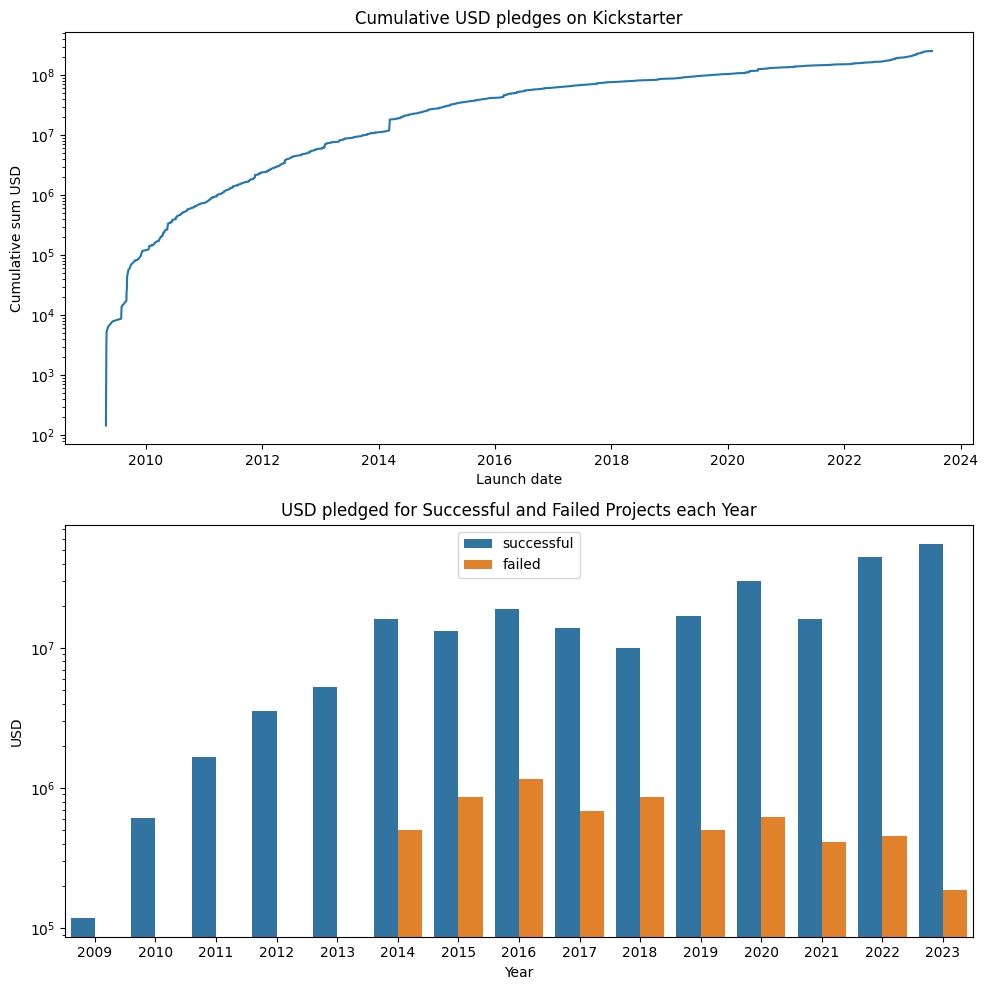

In [78]:
plt.figure(figsize=(10, 10))

# Plotting the cumulative sum of backers per month (line plot)
plt.subplot(2, 1, 1)
plt.plot(cumulative_pledges)
plt.xlabel('Launch date')
plt.ylabel('Cumulative sum USD')
plt.yscale('log')
plt.title('Cumulative USD pledges on Kickstarter')


# Plotting the number of backers for successful and failed projects each year (bar plot)
plt.subplot(2, 1, 2)
sns.barplot(data=pledges_per_year,
            x='launched_at',
            y='sum_usd_pledged',
            hue='state')
plt.xlabel('Year')
plt.ylabel('USD')
plt.yscale('log')
plt.title('USD pledged for Successful and Failed Projects each Year')
plt.legend()

plt.tight_layout()
plt.show()

## Dataset Preprocessing to ML model


Certain features were preserved during the exploratory data analysis (EDA) phase; however, they must now be discarded to facilitate the utilization of machine learning models. This entails removing datetime-related features and features that have a direct correlation with the outcomes.

In [79]:
# df_preprocessed = df.drop(['backers_count', 'created_at', 'deadline',
#                            'launched_at', 'usd_pledged'], axis=1)

In [80]:
cols_to_drop = ['backers_count', 'created_at', 'deadline',
                'launched_at', 'usd_pledged', 'id']

In [81]:
pipeline = create_drop_cols_pipeline(cols_to_drop)

X_train_preprocessed = pipeline.fit_transform(X_train_clean)
X_val_preprocessed = pipeline.transform(X_val_clean)
X_test_preprocessed = pipeline.transform(X_test_clean)

In [82]:
X_train_preprocessed.head()

,creation_to_launch_hours,campaign_hours,name_length,description_length,usd_goal,main_category,sub_category,country,staff_pick,state,diff_main_category_goal,diff_sub_category_goal
14733,593.0,576.0,7,20,10225.763625,food,small batch,GB,True,successful,2256.112125,4734.289100
12280,45.0,1440.0,11,18,709.016710,food,no subcategory,NZ,False,successful,7260.634790,4290.983290
9768,72.0,720.0,4,25,5000.000000,food,community gardens,US,False,failed,2969.651500,800.000000
15556,723.0,720.0,5,22,10000.000000,music,pop,US,False,successful,6500.000000,6095.162725
12337,208.0,384.0,3,6,2000.000000,music,pop,US,False,successful,1500.000000,1904.837275


### Specify numerical, categorical and target columns  

In [92]:
# Select numerical columns
num_cols = X_train_preprocessed.select_dtypes([np.number]).columns.tolist()
print(num_cols)

['creation_to_launch_hours', 'campaign_hours', 'name_length', 'description_length', 'usd_goal', 'diff_main_category_goal', 'diff_sub_category_goal']


In [94]:
# Select categorical columns
cols = X_train_preprocessed.columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('state') # remove target
print(cat_cols)

['staff_pick', 'sub_category', 'country', 'main_category']


In [95]:
# Select target column
target = 'state'

### Check data distribution

As we will see next, there are several numerical features that are heavily positively skewed.

In [83]:
X_train_preprocessed.describe()

,creation_to_launch_hours,campaign_hours,name_length,description_length,usd_goal,diff_main_category_goal,diff_sub_category_goal
count,15375.000000,15375.000000,15375.000000,15375.000000,1.537500e+04,1.537500e+04,1.537500e+04
mean,1252.202602,804.807805,5.773593,17.523057,2.277309e+04,2.055731e+04,2.041044e+04
std,3543.059410,307.852409,2.647679,5.637571,2.580923e+05,2.576425e+05,2.576347e+05
min,0.000000,24.000000,1.000000,1.000000,6.436000e-01,0.000000e+00,0.000000e+00
25%,95.000000,720.000000,4.000000,14.000000,1.500000e+03,1.508146e+03,1.500000e+03
50%,340.000000,720.000000,6.000000,19.000000,4.800000e+03,3.216793e+03,3.500000e+03
75%,1020.500000,864.000000,8.000000,22.000000,1.193707e+04,8.739174e+03,8.830882e+03
max,93590.000000,2184.000000,16.000000,33.000000,2.000000e+07,1.999650e+07,1.999610e+07


#### Plot histograms for all numerical columns

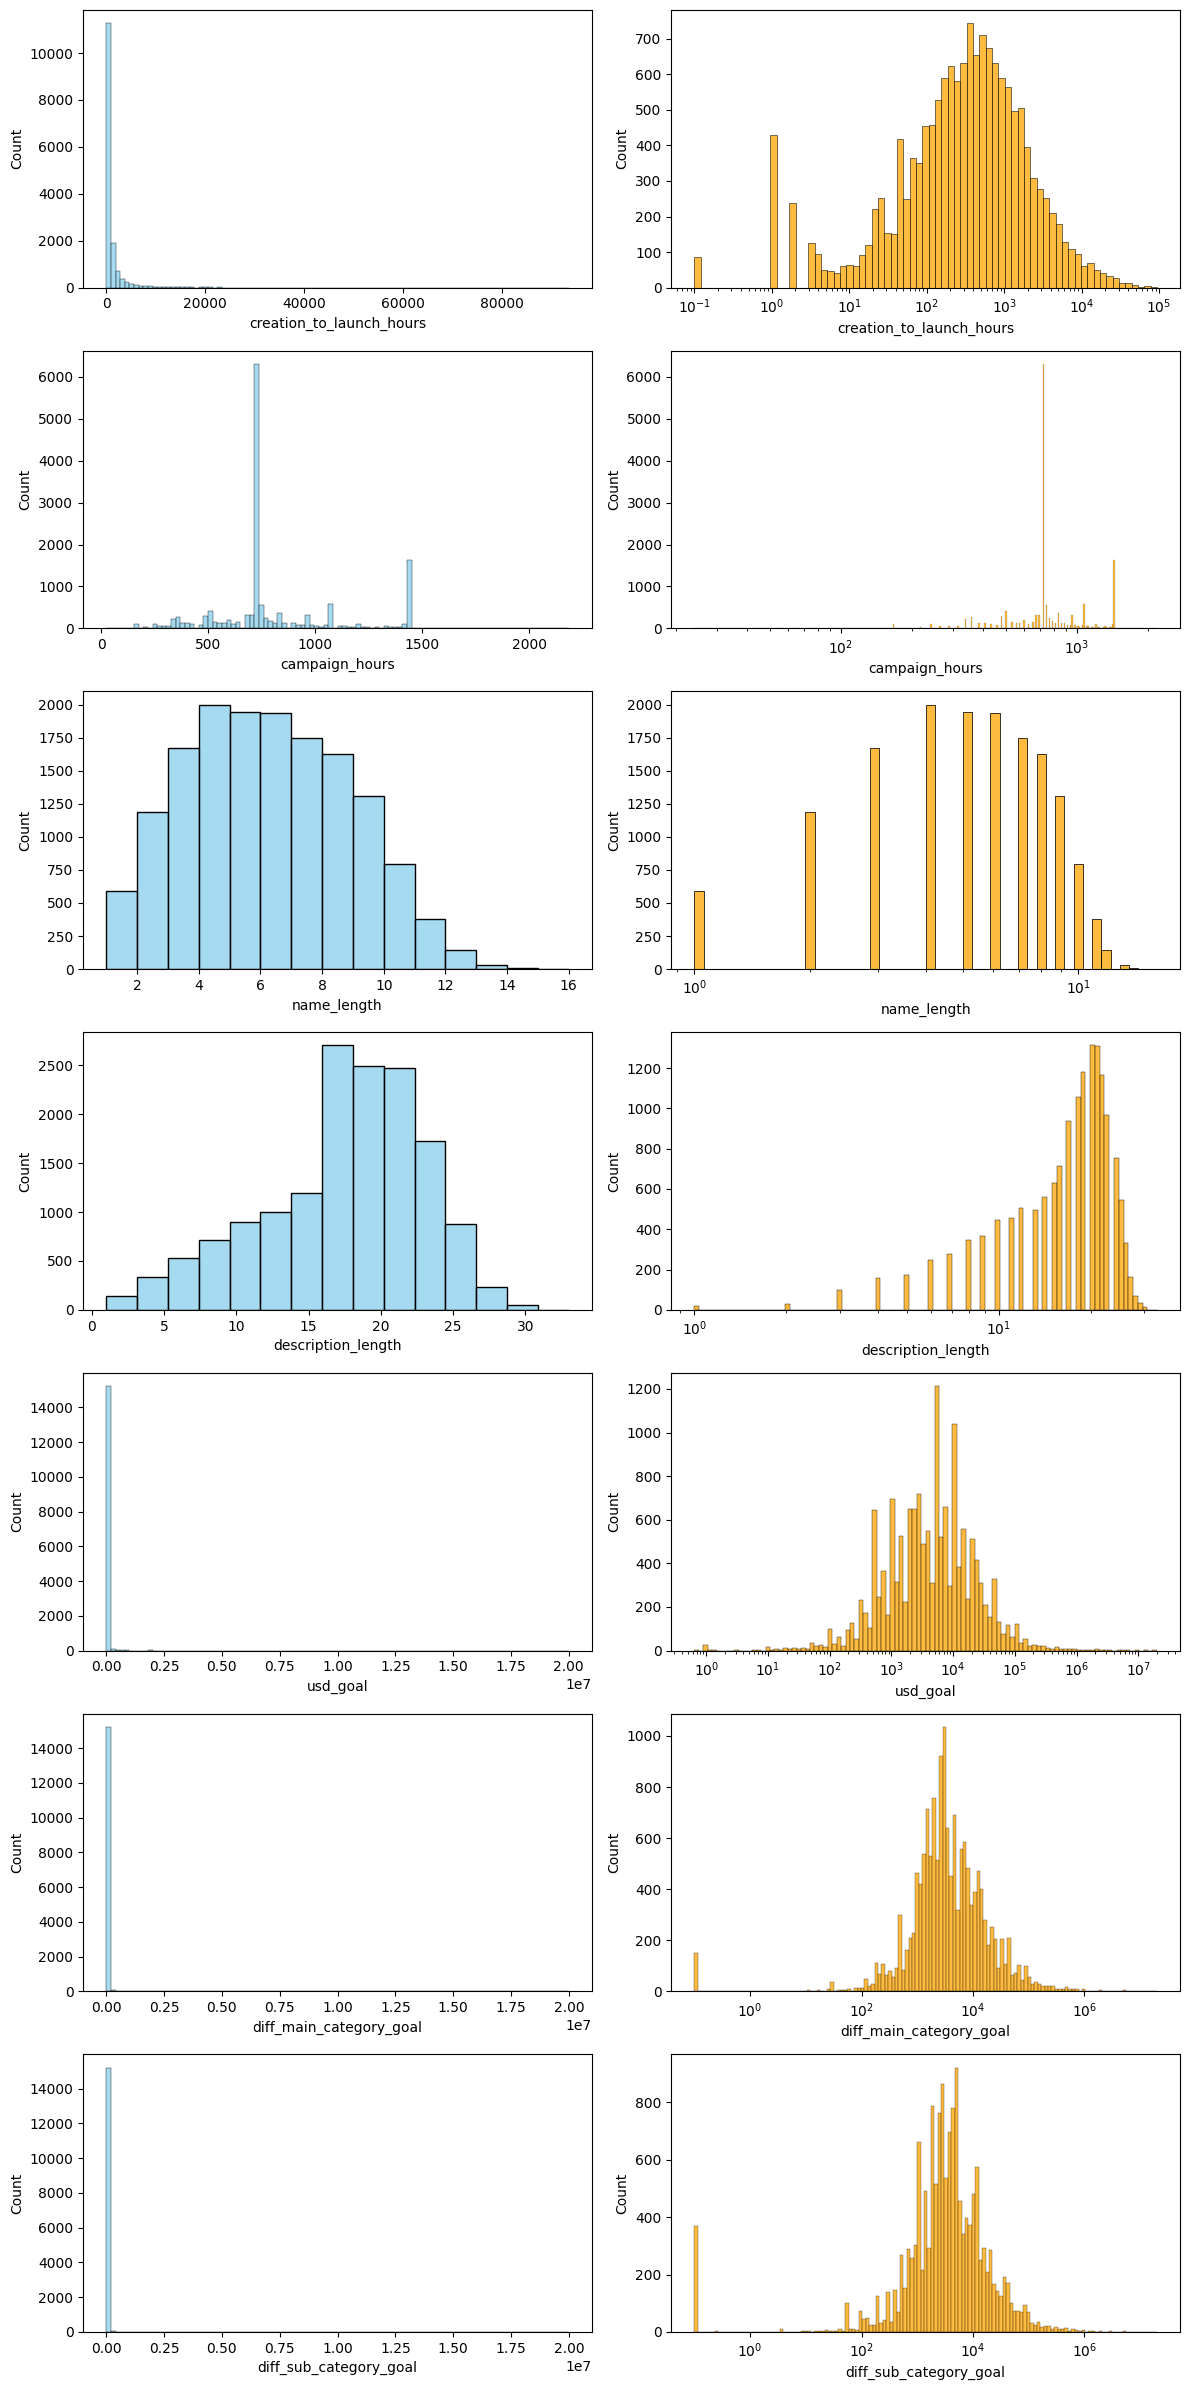

In [84]:
bins = [ 100 if X_train_preprocessed[col].nunique() > 50 else 15 
                                            for col in num_cols ]

# Create subplots with 7 rows and 2 columns
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 24))

# Loop through the columns and plot histograms
for i, column in enumerate(num_cols):
    # Take care of zeros for log
    df_to_plot = X_train_preprocessed[column] \
                        .astype('float64').replace(0.0, 0.1)
    # Plot without logx in the first column
    ax1 = axes[i, 0]
    sns.histplot(df_to_plot, ax=ax1, bins=bins[i], color='skyblue')

    # Plot with logx in the second column
    ax2 = axes[i, 1]
    sns.histplot(df_to_plot, ax=ax2, log_scale=True, color='orange')

plt.tight_layout()
plt.show()

#### Convert numerical to normal distribution

A log transformation will be applied to the skewed features (*usd_goal*, *creation_to_launch_hours*, *diff_main_category_goal*,*diff_sub_category_goal*) so that we now have all numerical columns following a normal distribution.

In [100]:
# numerical columns to be log-transformed
cols_to_log = ['usd_goal', 'creation_to_launch_hours', 
               'diff_main_category_goal', 'diff_sub_category_goal']
# remaining numerical cols + categorical
remaining_cols = list(set(num_cols) - set(cols_to_log) | \
                      set(cat_cols))

['sub_category',
 'staff_pick',
 'name_length',
 'description_length',
 'campaign_hours',
 'country',
 'main_category']

In [94]:
# # Replacing 0s with 0.1 and log-transforming
# df_preprocessed[cols_to_log] = np.log( 
#                                      df_preprocessed[cols_to_log] \
#                                      .astype('float64') \
#                                      .replace(0.0, 0.1)
#                                 )

In [105]:
# adds 1 to each value before taking the logarithm, which handles
# cases where the data contains zeros or negative values.
def custom_log_transform(X):
    return np.log1p(X)


preprocessor = ColumnTransformer(
    transformers=[
        ('log_scaled', FunctionTransformer(func=custom_log_transform), 
                                           cols_to_log),
        ('remaining', 'passthrough', remaining_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
preprocessor.set_output(transform="pandas")


pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

/home/javi/miniconda3/envs/mlops-zoomcamp/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [111]:
X_train_preprocessed = pipeline.fit_transform(X_train_preprocessed)
X_val_preprocessed = pipeline.transform(X_val_preprocessed)
X_test_preprocessed = pipeline.transform(X_test_preprocessed)

### Encode target column

In [115]:
y_train = X_train_preprocessed[target]
y_val = X_val_preprocessed[target]
y_test = X_test_preprocessed[target]

le = LabelEncoder()
# 0 -> failed; 1 -> successful
y_train_ready = le.fit_transform(y_train)
y_val_ready = le.transform(y_val)
y_test_ready = le.transform(y_test)

14733    successful
12280    successful
9768         failed
15556    successful
12337    successful
            ...    
17840        failed
18769        failed
19965    successful
22599        failed
22895    successful
Name: state, Length: 15375, dtype: object

In [118]:
# Drop the target from X
pipeline = create_drop_cols_pipeline(target)

X_train_preprocessed = pipeline.fit_transform(X_train_preprocessed)
X_val_preprocessed = pipeline.transform(X_val_preprocessed)
X_test_preprocessed = pipeline.transform(X_test_preprocessed)

,usd_goal,creation_to_launch_hours,diff_main_category_goal,diff_sub_category_goal,sub_category,staff_pick,name_length,description_length,campaign_hours,country,main_category
14733,9.232763,6.386879,7.721841,8.462798,small batch,True,7,20,576.0,GB,food
12280,6.565289,3.828641,8.890360,8.364504,no subcategory,False,11,18,1440.0,NZ,food
9768,8.517393,4.290459,7.996537,6.685861,community gardens,False,4,25,720.0,US,food
15556,9.210440,6.584791,8.779711,8.715415,pop,False,5,22,720.0,US,music
12337,7.601402,5.342334,7.313887,7.552677,pop,False,3,6,384.0,US,music
...,...,...,...,...,...,...,...,...,...,...,...
17840,6.311735,5.602119,7.989899,7.203735,punk,False,1,22,1440.0,US,music
18769,11.512935,7.611348,11.461643,11.461643,comedy,False,7,20,1440.0,US,film & video
19965,11.931642,6.349139,11.830735,11.843805,software,False,9,18,960.0,US,technology
22599,7.117748,7.608374,8.234388,8.234388,comedy,False,8,22,720.0,GB,film & video


### Scale numerical features and Encode categorical features

We have made sure that numerical features follow a normal distribution, thus we'll employ ```StandardScaler```. The categorical variables will be encoded with ```OneHotEncoder```.

In [136]:
numeric_preprocessor = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore",
                                 sparse_output=True))
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_cols),
        ("numerical", numeric_preprocessor, num_cols),
    ],
    verbose_feature_names_out=False
    # All cols are processed, so no need for 'passthrough'
)
#preprocessor.set_output(transform="pandas")


pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [137]:
X_train_ready = pipeline.fit_transform(X_train_preprocessed)
X_val_ready = pipeline.transform(X_val_preprocessed)
X_test_ready = pipeline.transform(X_test_preprocessed)

In [138]:
X_train_ready

<15375x80 sparse matrix of type '<class 'numpy.float64'>'
	with 169125 stored elements in Compressed Sparse Row format>

## ML Modeling

Six distinct classification machine learning models with default parameters will be employed on the dataset with the objective of developing a predictive framework capable of categorizing projects as either successful or unsuccessful.

In [174]:
# Initialize models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=500)),
    ("Decision Tree", DecisionTreeClassifier(random_state=SEED)),
    ("Random Forest", RandomForestClassifier(random_state=SEED)),
    ("AdaBoost", AdaBoostClassifier(random_state=SEED)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=SEED)),
    ("XGBoost", XGBClassifier(random_state=SEED))
]

In [175]:
# Define constants
n_folds = 5
scoring_metrics = ['f1', 'precision', 'recall', 'roc_auc']

names = []
results = []
run_times = []

# Loop through models
for name, model in models:
    
    kfold = KFold(n_splits=n_folds, shuffle=True, 
                  random_state=SEED)
    cv_results = cross_validate(model, 
                                X_train_ready, y_train_ready, 
                                cv=kfold, 
                                scoring=scoring_metrics,
                                return_train_score=True)
    
    names.append(name)
    results.append(cv_results)
    run_time = cv_results['fit_time'] + cv_results['score_time']
    run_times.append(run_time)
    
    msg = f"{name}:\n Run time: {run_time.mean():.3f}"\
          f" (+/- {run_time.std():.3f})\n"
    for metric in scoring_metrics:
        msg += f" {metric} (train) = {cv_results['train_' + metric].mean():.3f}"\
               f" (+/- {cv_results['train_' + metric].std():.3f})\n"\
               f" {metric} (val)   = {cv_results['test_' + metric].mean():.3f}"\
               f" (+/- {cv_results['test_' + metric].std():.3f})\n"
    print(msg)

Logistic Regression:
 Run time: 0.127 (+/- 0.013)
 f1 (train) = 0.873 (+/- 0.001)
 f1 (val)   = 0.871 (+/- 0.006)
 precision (train) = 0.871 (+/- 0.002)
 precision (val)   = 0.868 (+/- 0.007)
 recall (train) = 0.876 (+/- 0.002)
 recall (val)   = 0.874 (+/- 0.010)
 roc_auc (train) = 0.911 (+/- 0.001)
 roc_auc (val)   = 0.908 (+/- 0.005)

Decision Tree:
 Run time: 0.213 (+/- 0.013)
 f1 (train) = 1.000 (+/- 0.000)
 f1 (val)   = 0.832 (+/- 0.010)
 precision (train) = 1.000 (+/- 0.000)
 precision (val)   = 0.833 (+/- 0.011)
 recall (train) = 1.000 (+/- 0.000)
 recall (val)   = 0.832 (+/- 0.014)
 roc_auc (train) = 1.000 (+/- 0.000)
 roc_auc (val)   = 0.742 (+/- 0.011)

Random Forest:
 Run time: 3.634 (+/- 0.067)
 f1 (train) = 1.000 (+/- 0.000)
 f1 (val)   = 0.874 (+/- 0.008)
 precision (train) = 1.000 (+/- 0.000)
 precision (val)   = 0.867 (+/- 0.006)
 recall (train) = 1.000 (+/- 0.000)
 recall (val)   = 0.880 (+/- 0.012)
 roc_auc (train) = 1.000 (+/- 0.000)
 roc_auc (val)   = 0.905 (+/- 0.0

#### Plotting

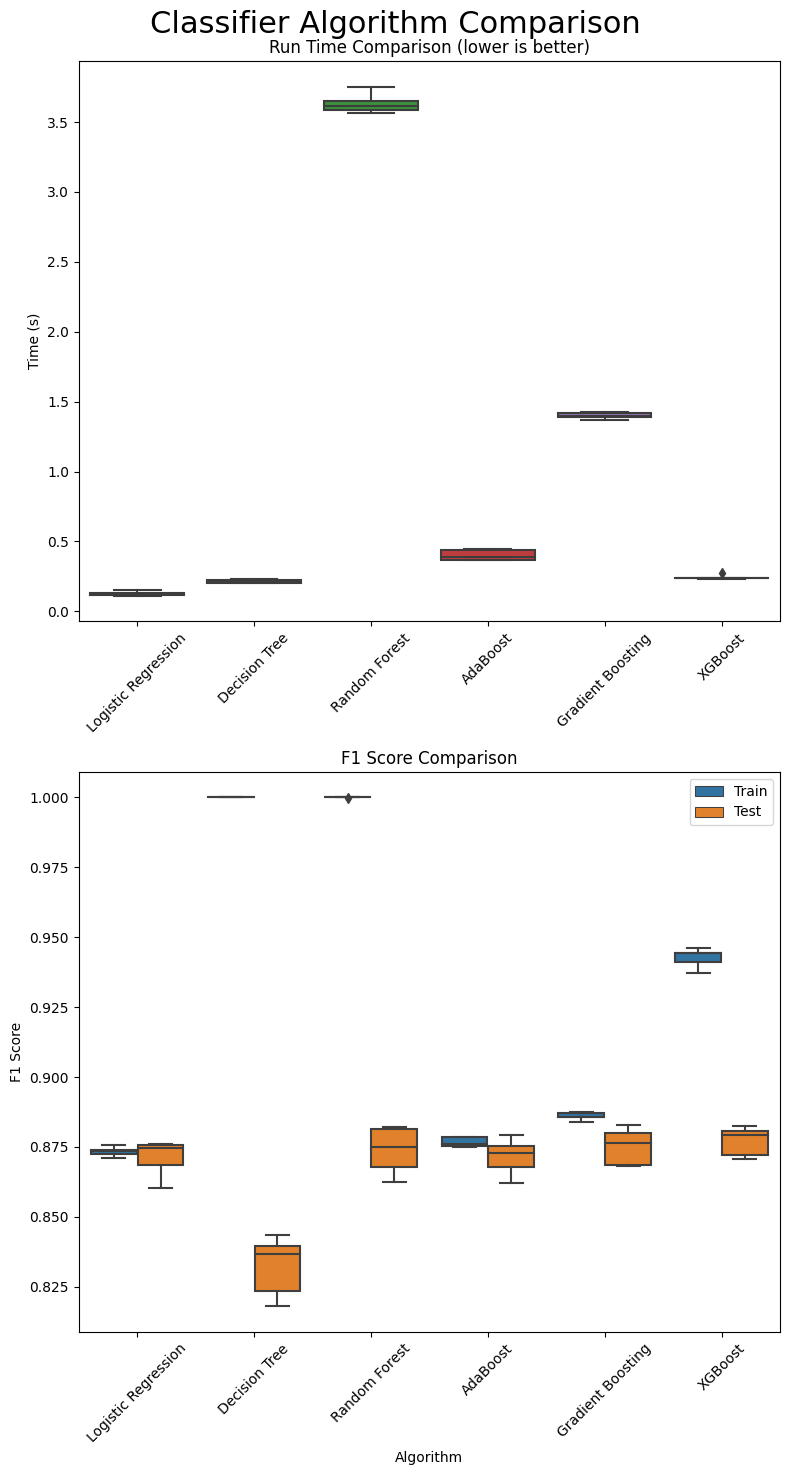

In [242]:
# Plot metrics for each model

run_times_df = pd.DataFrame(run_times, index=names).T

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 15))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)

# Boxplot for run times
sns.boxplot(data=run_times_df, ax=ax1)
ax1.set_title('Run Time Comparison (lower is better)')
ax1.set_ylabel('Time (s)')
ax1.set_xticklabels(names, rotation=45)

# Boxplot for train_f1 and test_f1
train_f1_scores = [result['train_f1'] for result in results]
test_f1_scores = [result['test_f1'] for result in results]

# Flatten the lists
train_f1_scores_flat = np.stack(train_f1_scores).T.reshape(-1)
test_f1_scores_flat = np.stack(test_f1_scores).T.reshape(-1)

f1_scores_df = pd.DataFrame({
    'Algorithm': (names * n_folds) * 2,
    'F1 Score': np.concatenate((train_f1_scores_flat,test_f1_scores_flat)),
    'Dataset': (['Train'] * len(train_f1_scores_flat) + ['Test'] * len(test_f1_scores_flat))
})

sns.boxplot(x='Algorithm', y='F1 Score', ax=ax2,
            hue='Dataset', data=f1_scores_df)

ax2.set_title('F1 Score Comparison')
ax2.set_ylabel('F1 Score')
ax2.set_xticklabels(names, rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

#### Prediction on test set

The validation set is skipped in this case, as we have used cross-validation within the training set.

In [243]:
# function to predict the specified scoring metrics on test set
def predict_metrics(model, X_train, y_train, X_test, y_test):
    metrics = {}
    
    for metric in scoring_metrics:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if metric == 'f1':
            metric_score = f1_score(y_test, y_pred)
        elif metric == 'precision':
            metric_score = precision_score(y_test, y_pred)
        elif metric == 'recall':
            metric_score = recall_score(y_test, y_pred)
        elif metric == 'roc_auc':
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            metric_score = roc_auc_score(y_test, y_pred_prob)
        
        metrics[metric] = metric_score
    
    return metrics

In [246]:
evaluation_results = []

for name, model in models:
    print(f"Evaluating {name}")
    evaluation = {}
    
    # Predict metrics on X_test
    evaluation['predict_metrics'] = predict_metrics(model, 
                                                    X_train_ready, y_train_ready, 
                                                    X_test_ready, y_test_ready)
    
    evaluation_results.append((name, evaluation))

    
for name, evaluation in evaluation_results:
    print(f"Model: {name}")
    print("Predicted metrics on test:", evaluation['predict_metrics'])

Evaluating Logistic Regression
Evaluating Decision Tree
Evaluating Random Forest
Evaluating AdaBoost
Evaluating Gradient Boosting
Evaluating XGBoost
Model: Logistic Regression
Predicted metrics on test: {'f1': 0.8760000000000001, 'precision': 0.8830645161290323, 'recall': 0.8690476190476191, 'roc_auc': 0.9092715069566921}
Model: Decision Tree
Predicted metrics on test: {'f1': 0.8364765919680498, 'precision': 0.8418937025457793, 'recall': 0.8311287477954145, 'roc_auc': 0.7516754850088184}
Model: Random Forest
Predicted metrics on test: {'f1': 0.8866476649857487, 'precision': 0.88181421718273, 'recall': 0.8915343915343915, 'roc_auc': 0.9166321689855641}
Model: AdaBoost
Predicted metrics on test: {'f1': 0.8713876020295609, 'precision': 0.8719646799116998, 'recall': 0.8708112874779541, 'roc_auc': 0.9053716359657717}
Model: Gradient Boosting
Predicted metrics on test: {'f1': 0.8807617398831423, 'precision': 0.8648533786655334, 'recall': 0.8972663139329806, 'roc_auc': 0.9104370794957216}
Mod

<Figure size 1200x600 with 0 Axes>

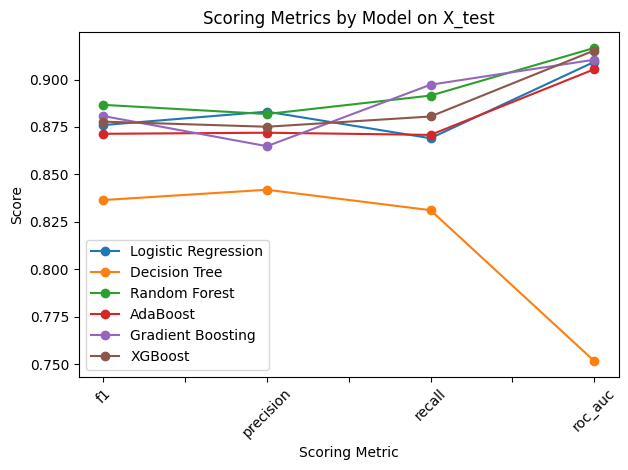

In [249]:
# Create a dictionary to store metric scores for plotting
metric_scores = {metric: [] for metric in scoring_metrics}

# Extract predicted scores for each model and metric
for name, evaluation in evaluation_results:
    for metric in scoring_metrics:
        metric_scores[metric].append(evaluation['predict_metrics'][metric])

# Create a DataFrame for metric scores
metric_scores_df = pd.DataFrame(metric_scores, 
                                index=[name for name, _ in evaluation_results])

# Plotting
plt.figure(figsize=(12, 6))
metric_scores_df.T.plot(kind='line', marker='o')
plt.title('Scoring Metrics by Model on X_test')
plt.xlabel('Scoring Metric')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()